In [448]:
import pandas as pd
from tabulate import tabulate
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
import optuna
from datetime import datetime, timedelta
import humanize

In [412]:
pd.set_option('display.float_format', '{:.2f}'.format)
random_state = 42

In [2]:
# Set default font
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

sns.set(font=font_prop.get_name())
mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.weight"] = 'semibold'

bold = 'extra bold'

sns.set_style(style='darkgrid')

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [4]:
df_dict = pd.read_excel('data/LCDataDictionary.xlsx')
df_dict

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed to settle for
149,settlement_percentage,The settlement amount as a percentage of the payoff balance amount on the loan
150,settlement_term,The number of months that the borrower will be on the settlement plan
151,NaN,NaN


In [5]:
df_dict.isna().sum()

LoanStatNew    2
Description    1
dtype: int64

In [6]:
df_dict.duplicated().sum()

0

In [7]:
df_dict.dropna(inplace=True)

In [8]:
df_dict.rename(columns={'LoanStatNew': 'column', 'Description': 'definition'}, inplace=True)

In [9]:
# split the text to lines of 80 characters
df_dict['definition'] = df_dict['definition'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=80)))

In [10]:
df_dict['column'].str.startswith(' ').sum()

0

In [11]:
df_dict['column'].str.endswith(' ').sum()

12

In [12]:
df_dict['column'] = df_dict['column'].str.strip()

In [13]:
print(tabulate(df_dict, headers='keys', tablefmt='pipe'))

|     | column                                     | definition                                                                       |
|----:|:-------------------------------------------|:---------------------------------------------------------------------------------|
|   0 | acc_now_delinq                             | The number of accounts on which the borrower is now delinquent.                  |
|   1 | acc_open_past_24mths                       | Number of trades opened in past 24 months.                                       |
|   2 | addr_state                                 | The state provided by the borrower in the loan application                       |
|   3 | all_util                                   | Balance to credit limit on all trades                                            |
|   4 | annual_inc                                 | The self-reported annual income provided by the borrower during registration.    |
|   5 | annual_inc_joint                        

In [14]:
with open('data/data_dictionary.md', 'w') as f:
    f.write(tabulate(df_dict, headers='keys', tablefmt='pipe'))

In [15]:
def column_definition(col, df_dict=df_dict):
    """Get the definition of a column in the dataset."""
    try:
        return df_dict[df_dict['column'] == col]['definition'].values[0]
    except IndexError:
        return 'Definition not found'

In [16]:
column_definition('loan_amnt')

'The listed amount of the loan applied for by the borrower. If at some point in\ntime, the credit department reduces the loan amount, then it will be reflected\nin this value.'

In [17]:
column_definition('column-not-found')

'Definition not found'

In [18]:
df0 = pd.read_csv('data/loan.csv', low_memory=False)
df0

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.020000,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.110000,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,D

<IPython.core.display.Javascript object>

In [19]:
set(df0.columns) - set(df_dict['column'])

{'verification_status_joint'}

In [20]:
set(df_dict['column']) - set(df0.columns)

{'fico_range_high',
 'fico_range_low',
 'last_fico_range_high',
 'last_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'verified_status_joint'}

Let's see if the missing `verification_status_joint` column is in fact the
same as `verified_status_joint` in the data dictionary.

In [21]:
print(column_definition('verified_status_joint'))

Indicates if the co-borrowers' joint income was verified by LC, not verified, or
if the income source was verified


In [22]:
df0['verification_status_joint'].value_counts(dropna=False)

verification_status_joint
NaN                2144938
Not Verified         57403
Source Verified      34827
Verified             23500
Name: count, dtype: int64

Seems to be the same column. Let's rename it to `verification_status_joint`.

In [23]:
# change verified_status_joint to verification_status_joint
df_dict.loc[df_dict['column'] == 'verified_status_joint', 'column'] = 'verification_status_joint'

In [24]:
set(df0.columns) - set(df_dict['column'])

set()

In [25]:
print(column_definition('verification_status_joint'))

Indicates if the co-borrowers' joint income was verified by LC, not verified, or
if the income source was verified


Now we have definitions for all columns in the dataset.

In [26]:
nan_df = df0.isna().sum().to_frame('count')
nan_df['percentage'] = (nan_df['count'] / len(df0) * 100).map('{:.2f}%'.format)

In [27]:
print(nan_df[nan_df['count'] > 0].sort_values(['count'], ascending=False).to_string())

                                              count percentage
id                                          2260668    100.00%
url                                         2260668    100.00%
member_id                                   2260668    100.00%
orig_projected_additional_accrued_interest  2252242     99.63%
hardship_length                             2250055     99.53%
hardship_reason                             2250055     99.53%
hardship_status                             2250055     99.53%
deferral_term                               2250055     99.53%
hardship_amount                             2250055     99.53%
hardship_start_date                         2250055     99.53%
hardship_end_date                           2250055     99.53%
payment_plan_start_date                     2250055     99.53%
hardship_loan_status                        2250055     99.53%
hardship_dpd                                2250055     99.53%
hardship_payoff_balance_amount              2250055    

Columns id, url, and member_id have no data. Let's drop them.

In [316]:
df = df0.copy()
df.drop(columns=['id', 'url', 'member_id'], inplace=True)

/tmp/ipykernel_5266/1663575970.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{i}%' for i in range(0, max_percentage, 10)])


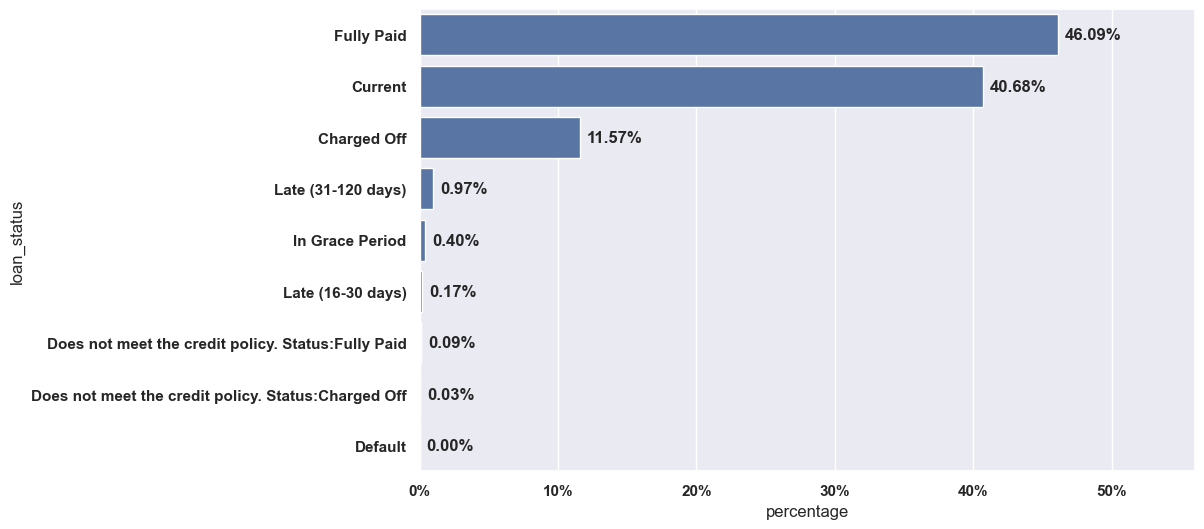

In [317]:
# loan_status counts
viz_df = df['loan_status'].value_counts(dropna=False).to_frame('count')
viz_df['percentage'] = (viz_df['count'] / len(df) * 100)
viz_df['percentage_txt'] = viz_df['percentage'].map('{:.2f}%'.format)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=viz_df,
    x='percentage',
    y=viz_df.index
    )

max_percentage = viz_df['percentage'].max().astype(int) + 10

ax.set_xticklabels([f'{i}%' for i in range(0, max_percentage, 10)])

ax.set_xlim(0, max_percentage)

for i, row in viz_df.iterrows():
    ax.text(row['percentage'] + 0.5, i, row['percentage_txt'], va='center')

plt.show()

In [318]:
print(column_definition('loan_status'))

Current status of the loan


We could define a default as a loan in status `Default` or in status `Charged Off`. We will keep the defaults according to this definition, and the fully paid loans. 

In [319]:
df = df[df['loan_status'].isin(['Default', 'Charged Off', 'Fully Paid'])].copy()
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.00,26.44,0.00,0.0,0.0,Jan-2019,30082.32,NaN,Jan-2019,0.0,NaN,1,Joint App,150000.0,23.38,Source Verified,0.0,0.0,472330.0,1.0,3.0,2.0,2.0,2.0,82850.0,75.0,0.0,1.0,9713.0,60.0,42200.0,1.0,1.0,3.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,NaN,8.0,NaN,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,Fully Paid,n,NaN,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.00,856.68,0.00,0.0,0.0,Feb-2019,40910.48,NaN,Feb-2019,0.0,NaN,1,Joint App,92000.0,35.66,Verified,0.0,0.0,271068.0,2.0,8.0,3.0,4.0,5.0,126749.0,87.0,1.0,1.0,5874.0,75.0,54200.0,4.0,2.0,4.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,NaN,9.0,NaN,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,47188.0,Apr-1990,0.0,1.0,32.0,61.1,16.0,19.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-201

In [320]:
print(column_definition('orig_projected_additional_accrued_interest'))

The original projected additional interest amount that will accrue for the given
hardship payment plan as of the Hardship Start Date. This field will be null if
the borrower has broken their hardship payment plan.


In [321]:
print(column_definition('deferral_term'))

Amount of months that the borrower is expected to pay less than the contractual
monthly payment amount due to a hardship plan


In [322]:
print(column_definition('payment_plan_start_date'))

The day the first hardship plan payment is due. For example, if a borrower has a
hardship plan period of 3 months, the start date is the start of the three-month
period in which the borrower is allowed to make interest-only payments.


Most of those NaN are due to the user not having a hardship plan.

In [323]:
df['hardship_flag'].value_counts(dropna=False)

hardship_flag
N    1303637
Y          1
Name: count, dtype: int64

No nulls in the flag, let's use it.

In [324]:
non_hardship_nan_df = df[df['hardship_flag'] == 'Y'].isna().sum().to_frame('count')
non_hardship_nan_df['percentage'] = (non_hardship_nan_df['count'] / len(df) * 100).map('{:.2f}%'.format)
print(non_hardship_nan_df[non_hardship_nan_df['count'] > 0].sort_values(['count'], ascending=False).to_string())

                                     count percentage
desc                                     1      0.00%
mths_since_last_record                   1      0.00%
settlement_percentage                    1      0.00%
settlement_amount                        1      0.00%
settlement_date                          1      0.00%
settlement_status                        1      0.00%
debt_settlement_flag_date                1      0.00%
sec_app_mths_since_last_major_derog      1      0.00%
sec_app_collections_12_mths_ex_med       1      0.00%
sec_app_chargeoff_within_12_mths         1      0.00%
sec_app_num_rev_accts                    1      0.00%
sec_app_open_act_il                      1      0.00%
sec_app_revol_util                       1      0.00%
sec_app_open_acc                         1      0.00%
sec_app_mort_acc                         1      0.00%
sec_app_inq_last_6mths                   1      0.00%
sec_app_earliest_cr_line                 1      0.00%
revol_bal_joint             

The number of NaNs for the first few columns is the same as the number of users with `hardship flag == 'Y'`

In [325]:
print(column_definition('settlement_term'))

The number of months that the borrower will be on the settlement plan


In [326]:
print(column_definition('settlement_status'))

The status of the borrower’s settlement plan. Possible values are: COMPLETE,
ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT


In [327]:
print(column_definition('sec_app_mths_since_last_major_derog'))

 Months since most recent 90-day or worse rating at time of application for the
secondary applicant


In [328]:
print(column_definition('revol_bal_joint'))

 Sum of revolving credit balance of the co-borrowers, net of duplicate balances


In [329]:
df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,26.44,0.0,0.0,0.0,Jan-2019,30082.32,NaN,Jan-2019,0.0,NaN,1,Joint App,150000.0,23.38,Source Verified,0.0,0.0,472330.0,1.0,3.0,2.0,2.0,2.0,82850.0,75.0,0.0,1.0,9713.0,60.0,42200.0,1.0,1.0,3.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,NaN,8.0,NaN,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,Fully Paid,n,NaN,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,856.68,0.0,0.0,0.0,Feb-2019,40910.48,NaN,Feb-2019,0.0,NaN,1,Joint App,92000.0,35.66,Verified,0.0,0.0,271068.0,2.0,8.0,3.0,4.0,5.0,126749.0,87.0,1.0,1.0,5874.0,75.0,54200.0,4.0,2.0,4.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,NaN,9.0,NaN,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,47188.0,Apr-1990,0.0,1.0,32.0,61.1,16.0,19.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,Fu

In [330]:
columns_to_keep = set(['loan_amnt'])

In [331]:
print(column_definition('funded_amnt'))

The total amount committed to that loan at that point in time.


In [332]:
print(column_definition('funded_amnt_inv'))

The total amount committed by investors for that loan at that point in time.


In [333]:
columns_to_keep.add('term')

In [334]:
columns_to_keep.add('int_rate')

In [335]:
print(column_definition('installment'))

The monthly payment owed by the borrower if the loan originates.


In [336]:
columns_to_keep.add('installment')

In [337]:
columns_to_keep.add('sub_grade')

In [338]:
print(column_definition('emp_title'))

The job title supplied by the Borrower when applying for the loan.*


Let's drop this column, it seems to be a text field provided by the user.

In [339]:
columns_to_keep.add('emp_length')

In [340]:
columns_to_keep = columns_to_keep.union(
        set(['home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status'])
        )

Is `last_credit_pull_d` available at the time of inference (moment of application)?

In [341]:
df[['issue_d', 'last_credit_pull_d']]

,issue_d,last_credit_pull_d
100,Dec-2018,Jan-2019
152,Dec-2018,Feb-2019
170,Dec-2018,Feb-2019
186,Dec-2018,Feb-2019
215,Dec-2018,Feb-2019
...,...,...
2260654,Oct-2017,Dec-2018
2260655,Oct-2017,Jan-2019
2260656,Oct-2017,Feb-2019
2260658,Oct-2017,Feb-2019


Nope, it gets overwritten.

In [342]:
columns_to_keep

{'annual_inc',
 'emp_length',
 'home_ownership',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'loan_status',
 'sub_grade',
 'term',
 'verification_status'}

In [343]:
print(column_definition('pymnt_plan'))

Indicates if a payment plan has been put in place for the loan


In [344]:
df.groupby(['purpose', 'title']).size()

purpose  title                              
car       APRILIA TUONO 1000R                   1
          Auto                                  1
          Auto Loan                             2
          Winter Vehicle needed 4wheel drive    1
          Work Car Funding                      1
                                               ..
wedding  wedds                                  1
         weding                                 1
         weeding                                1
         wonderful wedding                      1
         youngest daughter                      1
Length: 69649, dtype: int64

In [345]:
df['purpose'].value_counts()

purpose
debt_consolidation    757610
credit_card           285708
home_improvement       84497
other                  74937
major_purchase         28328
medical                15024
small_business         15010
car                    14121
moving                  9173
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: count, dtype: int64

In [346]:
df['title'].nunique()

61677

In [347]:
columns_to_keep.add('purpose')

Let's just use the state, using the first 3 digits of the zip code seems a bit overkill for this first iteration.

In [348]:
columns_to_keep.add('addr_state')

In [349]:
(df['earliest_cr_line'].str.split('-').str[1].astype(int) > df['issue_d'].str.split('-').str[1].astype(int)).sum()

0

Field `earliest_cr_line` is not updated after the loan, it should be available at the time of inference.

In [350]:
columns_to_keep.add('earliest_cr_line')

In [351]:
print(column_definition('dti'))

A ratio calculated using the borrower’s total monthly debt payments on the total
debt obligations, excluding mortgage and the requested LC loan, divided by the
borrower’s self-reported monthly income.


In [352]:
columns_to_keep.add('dti')

In [353]:
print(column_definition('delinq_2yrs'))

The number of 30+ days past-due incidences of delinquency in the borrower's
credit file for the past 2 years


Note sure if this is updated after the loan is issued.

In [354]:
print(column_definition('initial_list_status'))

The initial listing status of the loan. Possible values are – W, F


In [355]:
columns_to_keep.add('initial_list_status')

In [356]:
print(column_definition('disbursement_method'))

The method by which the borrower receives their loan. Possible values are: CASH,
DIRECT_PAY


In [357]:
columns_to_keep.add('disbursement_method')

In [358]:
columns_to_keep

{'addr_state',
 'annual_inc',
 'disbursement_method',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'home_ownership',
 'initial_list_status',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status'}

In [359]:
cols = [col for col in df.columns if col in columns_to_keep]
df = df[cols].copy()

In [360]:
df['default'] = np.where(df['loan_status'] == 'Fully Paid', 0, 1)
df.drop(columns=['loan_status'], inplace=True)

In [361]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,initial_list_status,disbursement_method,default
100,30000,36 months,22.35,1151.16,D5,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,debt_consolidation,CA,30.46,Jan-2012,w,Cash,0
152,40000,60 months,16.14,975.71,C4,< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,credit_card,OH,50.53,Jun-2009,w,Cash,0
170,20000,36 months,7.56,622.68,A3,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,credit_card,WA,18.92,Feb-1999,w,Cash,0
186,4500,36 months,11.31,147.99,B3,10+ years,RENT,38500.0,Not Verified,Dec-2018,credit_card,TX,4.64,Dec-2003,w,Cash,0
215,8425,36 months,27.27,345.18,E5,3 years,MORTGAGE,450000.0,Verified,Dec-2018,credit_card,MA,12.37,Oct-1997,w,Cash,0


In [362]:
df['term'].value_counts()

term
36 months    988774
60 months    314864
Name: count, dtype: int64

In [363]:
# Keep only number of months
df['term'] = df['term'].str.replace('\D', '', regex=True).astype(int)

In [364]:
df.rename(columns={'term': 'term_in_months'}, inplace=True)

In [365]:
df['term_in_months'].value_counts()

term_in_months
36    988774
60    314864
Name: count, dtype: int64

In [366]:
df['sub_grade'].value_counts().sort_index().to_frame().style.background_gradient()

,count
sub_grade,
A1,41258
A2,35800
A3,36600
A4,50519
A5,62068
B1,68853
B2,71691
B3,79425
B4,80607


These look ordinal. Let's check.

In [367]:
def get_text_coordinates(text_element, ax, fig):
    """
    Get the coordinates of a text element on a given axis of a given figure.
    Used to position elements on the canvas.

    Parameters:
    text_element: Text element to get the coordinates of.
    ax: Axis of the figure.
    fig: Figure to get the coordinates of the text element on.

    Returns:
    Dictionary with the following keys:
    x0: coordinate of the text element on the x-axis.
    x1: coordinate of the text element on the x-axis.
    y0: coordinate of the text element on the y-axis.
    y1: coordinate of the text element on the y-axis.
    """
    x0 = text_element.get_window_extent(fig.canvas.get_renderer()).x0
    x1 = text_element.get_window_extent(fig.canvas.get_renderer()).x1
    y0 = text_element.get_window_extent(fig.canvas.get_renderer()).y0
    y1 = text_element.get_window_extent(fig.canvas.get_renderer()).y1
    return {
             'x0': round(ax.transData.inverted().transform_point((x0, 0))[0], 2),
             'x1': round(ax.transData.inverted().transform_point((x1, 0))[0], 2),
             'y0': round(ax.transData.inverted().transform_point((0, y0))[1], 2),
             'y1': round(ax.transData.inverted().transform_point((0, y1))[1], 2)
           }

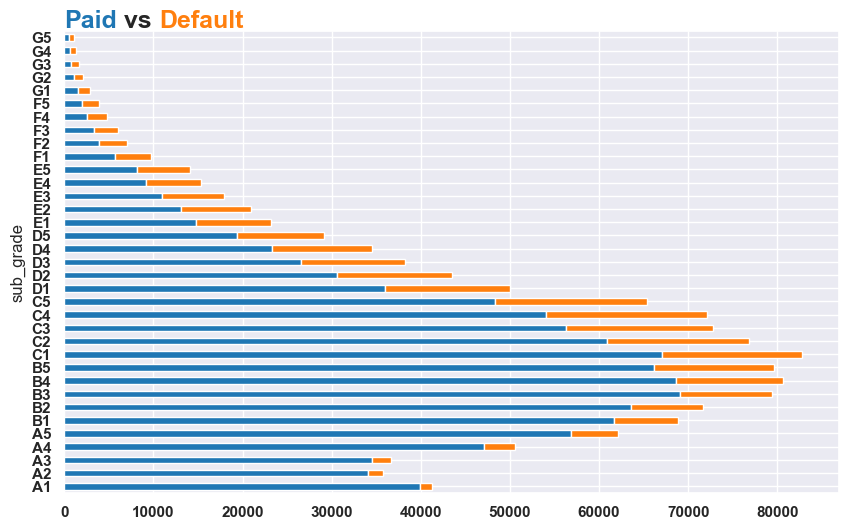

In [368]:
# create a stacked bar plot
viz_df = df.groupby(['sub_grade', 'default']).size().unstack().fillna(0).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

zero_color = '#1f77b4'
one_color = '#ff7f0e'

viz_df.plot.barh(
    x='sub_grade',
    y=[0, 1],
    stacked=True,
    ax=ax,
    color=[zero_color, one_color],
    )

# hide legend
ax.get_legend().remove()

title_font_size = 18

# set title
title = ax.set_title(
        '_',
        fontsize=title_font_size,
        fontweight=bold
        )

coords = get_text_coordinates(title, ax, fig)
y0 = coords['y0']
title.set_visible(False)

x0 = 0

__text = ax.text(
        x=x0,
        y=y0,
        s='Paid',
        fontsize=title_font_size,
        fontweight=bold,
        color=zero_color,
        ha='left'
        )

x1 = get_text_coordinates(__text, ax, fig)['x1']

__text = ax.text(
        x=x1,
        y=y0,
        s=' vs ',
        fontsize=title_font_size,
        ha='left'
        )

x1 = get_text_coordinates(__text, ax, fig)['x1']

ax.text(
        x=x1,
        y=y0,
        s='Default',
        fontsize=title_font_size,
        fontweight=bold,
        color=one_color,
        ha='left'
        )

plt.show()

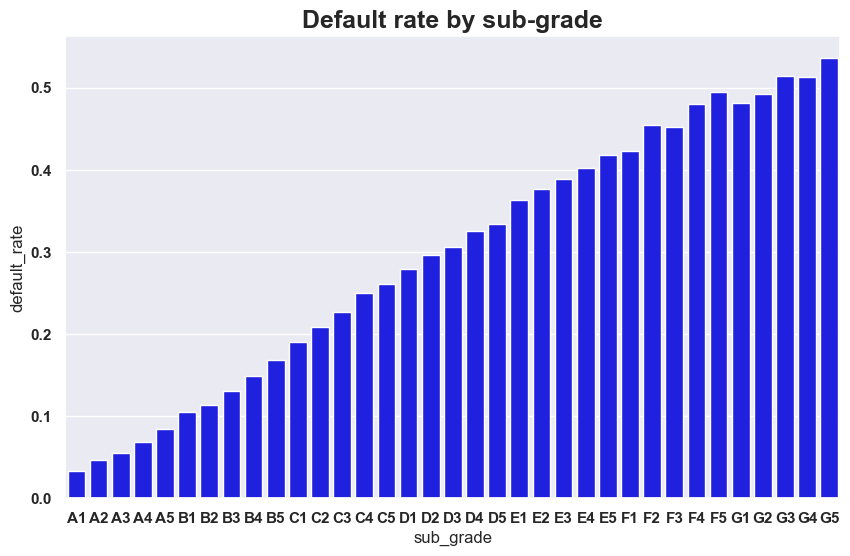

In [369]:
viz_df = df.groupby(['sub_grade', 'default']).size().unstack().fillna(0).reset_index()
viz_df['default_rate'] = viz_df[1] / (viz_df[0] + viz_df[1])

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=viz_df,
    x='sub_grade',
    y='default_rate',
    color='blue'
    )

ax.set_title('Default rate by sub-grade', fontsize=18, fontweight=bold)

plt.show()

Definitely ordinal.

In [370]:
grades = df['sub_grade'].unique()
grades.sort()
grades

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

In [371]:
grade_map = {grade: i for i, grade in enumerate(grades)}
df['sub_grade_ordinal'] = df['sub_grade'].map(grade_map)

In [372]:
df[['sub_grade', 'sub_grade_ordinal']].head()

,sub_grade,sub_grade_ordinal
100,D5,19
152,C4,13
170,A3,2
186,B3,7
215,E5,24


In [373]:
df.drop('sub_grade', axis=1, inplace=True)

In [374]:
df.head()

,loan_amnt,term_in_months,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,initial_list_status,disbursement_method,default,sub_grade_ordinal
100,30000,36,22.35,1151.16,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,debt_consolidation,CA,30.46,Jan-2012,w,Cash,0,19
152,40000,60,16.14,975.71,< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,credit_card,OH,50.53,Jun-2009,w,Cash,0,13
170,20000,36,7.56,622.68,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,credit_card,WA,18.92,Feb-1999,w,Cash,0,2
186,4500,36,11.31,147.99,10+ years,RENT,38500.0,Not Verified,Dec-2018,credit_card,TX,4.64,Dec-2003,w,Cash,0,7
215,8425,36,27.27,345.18,3 years,MORTGAGE,450000.0,Verified,Dec-2018,credit_card,MA,12.37,Oct-1997,w,Cash,0,24


In [375]:
df['emp_length'].value_counts(dropna=False)

emp_length
10+ years    428553
2 years      117825
< 1 year     104552
3 years      104204
1 year        85678
5 years       81623
4 years       78033
NaN           75457
6 years       60934
8 years       59127
7 years       58148
9 years       49504
Name: count, dtype: int64

In [376]:
df['emp_length_in_years'] = df['emp_length'].replace({
    '< 1 year': '0 years',
    '10+ years': '10 years',
    '1 year': '1 years',
    }).str.replace('\D+', '', regex=True).astype(float)

df.drop('emp_length', axis=1, inplace=True)

In [377]:
df['emp_length_in_years'].value_counts(dropna=False)

emp_length_in_years
10.0    428553
2.0     117825
0.0     104552
3.0     104204
1.0      85678
5.0      81623
4.0      78033
NaN      75457
6.0      60934
8.0      59127
7.0      58148
9.0      49504
Name: count, dtype: int64

In [378]:
df.head()

,loan_amnt,term_in_months,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,initial_list_status,disbursement_method,default,sub_grade_ordinal,emp_length_in_years
100,30000,36,22.35,1151.16,MORTGAGE,100000.0,Source Verified,Dec-2018,debt_consolidation,CA,30.46,Jan-2012,w,Cash,0,19,5.0
152,40000,60,16.14,975.71,MORTGAGE,45000.0,Verified,Dec-2018,credit_card,OH,50.53,Jun-2009,w,Cash,0,13,0.0
170,20000,36,7.56,622.68,MORTGAGE,100000.0,Not Verified,Dec-2018,credit_card,WA,18.92,Feb-1999,w,Cash,0,2,10.0
186,4500,36,11.31,147.99,RENT,38500.0,Not Verified,Dec-2018,credit_card,TX,4.64,Dec-2003,w,Cash,0,7,10.0
215,8425,36,27.27,345.18,MORTGAGE,450000.0,Verified,Dec-2018,credit_card,MA,12.37,Oct-1997,w,Cash,0,24,3.0


In [379]:
df['issued_month'] = df['issue_d'].str.split('-').str[0]
# To use in conjunction with the year of earliest credit line
df['issued_year'] = df['issue_d'].str.split('-').str[1].astype(int)

df.drop('issue_d', axis=1, inplace=True)

In [380]:
df['issued_month'].value_counts()

issued_month
Oct    133715
Jul    126658
Mar    115559
Nov    111197
Jan    110798
Aug    109434
Apr    106645
Dec    102109
May    101646
Feb     99947
Jun     97771
Sep     88159
Name: count, dtype: int64

In [391]:
df['earliest_cr_line_month'] = df['earliest_cr_line'].str.split('-').str[0]
df['earliest_cr_line_year'] = df['earliest_cr_line'].str.split('-').str[1].astype(int)

df['cr_line_years_ago'] = df['issued_year'] - df['earliest_cr_line_year']

In [392]:
df['earliest_cr_line_month'].value_counts()

earliest_cr_line_month
Aug    128812
Sep    127196
Oct    125405
Nov    114604
Mar    106100
Jul    105364
Dec    104706
May    101703
Jun    100797
Apr     98899
Jan     95519
Feb     94533
Name: count, dtype: int64

In [393]:
df['cr_line_years_ago'].describe()

count   1303638.00
mean         16.27
std           7.50
min           3.00
25%          11.00
50%          15.00
75%          20.00
max          83.00
Name: cr_line_years_ago, dtype: float64

In [394]:
df.drop([
          'issued_year',
          'earliest_cr_line',
          'earliest_cr_line_year'
        ],
        axis=1,
        inplace=True)

In [395]:
df.head()

,loan_amnt,term_in_months,int_rate,installment,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,initial_list_status,disbursement_method,default,sub_grade_ordinal,emp_length_in_years,issued_month,earliest_cr_line_month,cr_line_years_ago
100,30000,36,22.35,1151.16,MORTGAGE,100000.00,Source Verified,debt_consolidation,CA,30.46,w,Cash,0,19,5.00,Dec,Jan,6
152,40000,60,16.14,975.71,MORTGAGE,45000.00,Verified,credit_card,OH,50.53,w,Cash,0,13,0.00,Dec,Jun,9
170,20000,36,7.56,622.68,MORTGAGE,100000.00,Not Verified,credit_card,WA,18.92,w,Cash,0,2,10.00,Dec,Feb,19
186,4500,36,11.31,147.99,RENT,38500.00,Not Verified,credit_card,TX,4.64,w,Cash,0,7,10.00,Dec,Dec,15
215,8425,36,27.27,345.18,MORTGAGE,450000.00,Verified,credit_card,MA,12.37,w,Cash,0,24,3.00,Dec,Oct,21


In [396]:
len(df.columns)

18

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303638 entries, 100 to 2260664
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   loan_amnt               1303638 non-null  int64  
 1   term_in_months          1303638 non-null  int64  
 2   int_rate                1303638 non-null  float64
 3   installment             1303638 non-null  float64
 4   home_ownership          1303638 non-null  object 
 5   annual_inc              1303638 non-null  float64
 6   verification_status     1303638 non-null  object 
 7   purpose                 1303638 non-null  object 
 8   addr_state              1303638 non-null  object 
 9   dti                     1303326 non-null  float64
 10  initial_list_status     1303638 non-null  object 
 11  disbursement_method     1303638 non-null  object 
 12  default                 1303638 non-null  int64  
 13  sub_grade_ordinal       1303638 non-null  int64  
 14  emp_l

In [398]:
string_columns = [col for col in df.columns if df[col].dtype == 'object']
string_columns

['home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'disbursement_method',
 'issued_month',
 'earliest_cr_line_month']

In [399]:
df[string_columns].head()

,home_ownership,verification_status,purpose,addr_state,initial_list_status,disbursement_method,issued_month,earliest_cr_line_month
100,MORTGAGE,Source Verified,debt_consolidation,CA,w,Cash,Dec,Jan
152,MORTGAGE,Verified,credit_card,OH,w,Cash,Dec,Jun
170,MORTGAGE,Not Verified,credit_card,WA,w,Cash,Dec,Feb
186,RENT,Not Verified,credit_card,TX,w,Cash,Dec,Dec
215,MORTGAGE,Verified,credit_card,MA,w,Cash,Dec,Oct


In [401]:
df[list(set(df.columns) - set(string_columns))].head()

,loan_amnt,installment,sub_grade_ordinal,dti,default,annual_inc,int_rate,term_in_months,emp_length_in_years,cr_line_years_ago
100,30000,1151.16,19,30.46,0,100000.00,22.35,36,5.00,6
152,40000,975.71,13,50.53,0,45000.00,16.14,60,0.00,9
170,20000,622.68,2,18.92,0,100000.00,7.56,36,10.00,19
186,4500,147.99,7,4.64,0,38500.00,11.31,36,10.00,15
215,8425,345.18,24,12.37,0,450000.00,27.27,36,3.00,21


In [406]:
# one hot encode the string columns
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[string_columns])
encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [409]:
df_encoded = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(string_columns)
        ).astype(int)

df_encoded.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,disbursement_method_Cash,disbursement_method_DirectPay,issued_month_Apr,issued_month_Aug,issued_month_Dec,issued_month_Feb,issued_month_Jan,issued_month_Jul,issued_month_Jun,issued_month_Mar,issued_month_May,issued_month_Nov,issued_month_Oct,issued_month_Sep,earliest_cr_line_month_Apr,earliest_cr_line_month_Aug,earliest_cr_line_month_Dec,earliest_cr_line_month_Feb,earliest_cr_line_month_Jan,earliest_cr_line_month_Jul,earliest_cr_line_month_Jun,earliest_cr_line_month_Mar,earliest_cr_line_month_May,earliest_cr_line_month_Nov,earliest_cr_line_month_Oct,earliest_cr_line_month_Sep
0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [439]:
train_df = df.drop(string_columns, axis=1).copy().reset_index(drop=True)
train_df = pd.concat([train_df, df_encoded], axis=1)

float_columns = train_df.select_dtypes(include='float').columns
train_df[float_columns] = train_df[float_columns].round(2) # to handle float precision

train_df

,loan_amnt,term_in_months,int_rate,installment,annual_inc,dti,default,sub_grade_ordinal,emp_length_in_years,cr_line_years_ago,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,disbursement_method_Cash,disbursement_method_DirectPay,issued_month_Apr,issued_month_Aug,issued_month_Dec,issued_month_Feb,issued_month_Jan,issued_month_Jul,issued_month_Jun,issued_month_Mar,issued_month_May,issued_month_Nov,issued_month_Oct,issued_month_Sep,earliest_cr_line_month_Apr,earliest_cr_line_month_Aug,earliest_cr_line_month_Dec,earliest_cr_line_month_Feb,earliest_cr_line_month_Jan,earliest_cr_line_month_Jul,earliest_cr_line_month_Jun,earliest_cr_line_month_Mar,earliest_cr_line_month_May,earliest_cr_line_month_Nov,earliest_cr_line_month_Oct,earliest_cr_line_month_Sep
0,30000,36,22.35,1151.16,100000.00,30.46,0,19,5.00,6,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,40000,60,16.14,975.71,45000.00,50.53,0,13,0.00,9,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,20000,36,7.56,622.68,100000.00,18.92,0,2,10.00,19,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4500,36,11.31,147.99,38500.00,4.64,0,7,10.00,15,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,8425,36,27.27,345.18,450000.00,12.37,0,24,3.00,21,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303633,30000,60,17.09,747.03,80000.00,23.22,1,15,2.00,16,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1303634,18000,60,30.65,589.57,77000.00,8.08,1,28,10.0

In [440]:
len(train_df.columns)

112

## Model

We are going to use the following train-test split:
- 60% training set to train the model
- 20% validation set to tune the hyperparameters
- 20% test set to evaluate the model after tuning

In [441]:
X = train_df.drop('default', axis=1)
y = train_df['default']

X_train_val, X_test, y_train_val, y_test = train_test_split(
        X,
        y,
        test_size=0.20,
        stratify=y,
        random_state=random_state
        )

X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.25,
        stratify=y_train_val,
        random_state=random_state
        )

In [449]:
def run_study(objective, n_trials=50, direction='maximize'):
    started_at = datetime.now()

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    ended_at = datetime.now()

    duration_in_seconds = (ended_at - started_at).total_seconds()

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    print("Time taken:", humanize.naturaldelta(timedelta(seconds=duration_in_seconds)))

    return study, duration_in_seconds

In [450]:
def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        # 'max_depth': trial.suggest_int('max_depth', 2, 32),
        # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': random_state
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return metrics.roc_auc_score(y_val, y_pred)

In [451]:
def objective_rf(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        # 'max_depth': trial.suggest_int('max_depth', 2, 32),
        # 'n_estimators': trial.suggest_int('n_estimators', 2, 200),
        # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': random_state,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return metrics.roc_auc_score(y_val, y_pred)

In [452]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 6),
        # 'max_depth': trial.suggest_int('max_depth', 2, 32),
        # 'n_estimators': trial.suggest_int('n_estimators', 2, 200),
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
        # 'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
        # 'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        # 'gamma': trial.suggest_loguniform('gamma', 0.001, 10),
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 10),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 10),
        'random_state': random_state,
        'objective': 'binary:logistic',
        'n_jobs': -1
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return metrics.roc_auc_score(y_val, y_pred)

In [454]:
%%time

dt_study, dt_execution_seconds = run_study(objective_dt, n_trials=3)
rf_study, rf_execution_seconds = run_study(objective_rf, n_trials=3)
xgb_study, xgb_execution_seconds = run_study(objective_xgb, n_trials=3)

# dt_study, dt_execution_seconds = run_study(objective_dt, n_trials=100)
# rf_study, rf_execution_seconds = run_study(objective_rf, n_trials=100)
# xgb_study, xgb_execution_seconds = run_study(objective_xgb, n_trials=100)

[I 2025-03-01 22:24:31,154] A new study created in memory with name: no-name-82454868-4df6-4aa1-93a6-84ecb670e1c6


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-03-01 22:24:41,979] Trial 0 finished with value: 0.525140359366996 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.525140359366996.
[I 2025-03-01 22:24:51,207] Trial 1 finished with value: 0.5209027560358483 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.525140359366996.


[I 2025-03-01 22:25:01,828] A new study created in memory with name: no-name-b2bbd937-ad0c-4411-94cd-3e9bb740cccb


[I 2025-03-01 22:25:01,826] Trial 2 finished with value: 0.525140359366996 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.525140359366996.
Best parameters: {'max_depth': 8}
Best score: 0.525140359366996
Time taken: 30 seconds


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-03-01 22:25:19,982] Trial 0 finished with value: 0.5 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.5.
[I 2025-03-01 22:25:37,876] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.5.


[I 2025-03-01 22:26:00,697] A new study created in memory with name: no-name-cfd78e2c-f6cf-4c12-b032-35b419c65ac2


[I 2025-03-01 22:26:00,694] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 4}. Best is trial 0 with value: 0.5.
Best parameters: {'max_depth': 3}
Best score: 0.5
Time taken: 58 seconds


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-03-01 22:26:10,266] Trial 0 finished with value: 0.5320843891177112 and parameters: {'max_depth': 6}. Best is trial 0 with value: 0.5320843891177112.
[I 2025-03-01 22:26:18,590] Trial 1 finished with value: 0.5310807618755884 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.5320843891177112.
[I 2025-03-01 22:26:26,312] Trial 2 finished with value: 0.5310807618755884 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.5320843891177112.
Best parameters: {'max_depth': 6}
Best score: 0.5320843891177112
Time taken: 25 seconds
CPU times: user 14min 35s, sys: 3.25 s, total: 14min 38s
Wall time: 1min 55s


<IPython.core.display.Javascript object>

In [470]:
# create a df with the results
df_results = pd.DataFrame({
    'model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'roc_auc': [
        dt_study.best_value,
        rf_study.best_value,
        xgb_study.best_value
    ],
    'execution_seconds': [
        dt_execution_seconds,
        rf_execution_seconds,
        xgb_execution_seconds
    ]
})

In [472]:
df_results

,model,roc_auc,execution_seconds
0,Decision Tree,0.53,30.67
1,Random Forest,0.50,58.87
2,XGBoost,0.53,25.62


In [485]:
# calculate accuracy, precision, recall and f1-score
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    
    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)
    
    return accuracy, precision, recall, f1

In [480]:
best_dt = DecisionTreeClassifier(**dt_study.best_params)
best_rf = RandomForestClassifier(**rf_study.best_params)
best_xgb = XGBClassifier(**xgb_study.best_params)

best_dt.fit(X_train_val, y_train_val)
best_rf.fit(X_train_val, y_train_val)
best_xgb.fit(X_train_val, y_train_val)

''

''

<IPython.core.display.Javascript object>

In [486]:
# calculate metrics
dt_metrics = calculate_metrics(best_dt, X_test, y_test)
rf_metrics = calculate_metrics(best_rf, X_test, y_test)
xgb_metrics = calculate_metrics(best_xgb, X_test, y_test)

/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [487]:
dt_metrics

(0.801072381945936,
 0.5359596885020614,
 0.06706536484704893,
 0.1192133953741127)

In [488]:
rf_metrics

(0.7992659016292841, 0.0, 0.0, 0.0)

In [489]:
xgb_metrics

(0.8022345125955018,
 0.5480745341614907,
 0.08429982612683187,
 0.14612416579727425)

In [490]:
df_results['accuracy'] = [dt_metrics[0], rf_metrics[0], xgb_metrics[0]]
df_results['precision'] = [dt_metrics[1], rf_metrics[1], xgb_metrics[1]]
df_results['recall'] = [dt_metrics[2], rf_metrics[2], xgb_metrics[2]]
df_results['f1'] = [dt_metrics[3], rf_metrics[3], xgb_metrics[3]]

In [491]:
df_results

,model,roc_auc,execution_seconds,accuracy,precision,recall,f1
0,Decision Tree,0.53,30.67,0.80,0.54,0.07,0.12
1,Random Forest,0.50,58.87,0.80,0.00,0.00,0.00
2,XGBoost,0.53,25.62,0.80,0.55,0.08,0.15
